# This code augments and stores the images (both augmented and original images) on disk.
# Used on ball and batsman

### Augmentation used:
- ColorJitter,
- ChannelShuffle,
- HueSaturationValue,
- RGBShift
- RandomBrightnessContrast,
- RandomRotate90



In [6]:
import json
import random
from os.path import join, isdir, isfile
from os import makedirs
from pathlib import Path
import glob
import sys

import cv2
from tqdm.notebook import tqdm

from albumentations import Compose
import albumentations as A
from modules import ImageAnnotations, Bbox, coco_prepare

from uuid import uuid1
import shutil
from natsort import natsorted
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 12]

In [7]:
def group_aug(image, bboxes=[], p1=0, p2=0, p3=0, p4=0, p5=0, p6=0, p7=0):
    """
    Augmentation pipeline for generating images with bboxes
    """
    transform = Compose([
        A.Flip(p=p1),
        A.ChannelShuffle(p=p2),
        A.HueSaturationValue(p=p3),
        A.RGBShift(p=p4),
        A.RandomBrightnessContrast(p=p5),
        A.RandomRotate90(p=p6)       
    ],
        bbox_params=A.BboxParams(format='coco'),
        p=1.0)
    
    return transform(
        image=image,
        bboxes=bboxes
    )

# Augmentation probabilities

aug_prob = (
    [0, 0, 0, 0, 0, 0], # 0. Original images
    [0, 0, 0, 0, 0, 1], # 1. Rot90
    [0, 0, 0, 0, 1, 0], # 2. RandBriCon
    [0, 0, 0, 0, 1, 1], # 3. Rot90 + RandBriCon
    [1, 0, 0, 0, 0, 0], # 4.Flip (LR - UD)
    [1, 0, 1, 0, 0, 0], # 4.Flip (LR - UD) + HueSat
    [1, 0, 0, 1, 0, 0], # 4.Flip (LR - UD) + RGBSh
    [0, 0, 1, 0, 0, 0], # 6. HueSat
    [0, 0, 0, 1, 0, 0], # 7. RGBSh
    [0, 0, 1, 0, 1, 0], # 8. HueSat + RandBriCon
    [0, 0, 0, 1, 1, 0], # 9. ChanSh + RandBri
    [0, 0, 1, 0, 0, 1], # 10. HueSat + Rot90
    [1, 0, 0, 1, 1, 0] # 11. Flip + RandBriCon + RGBSh
)


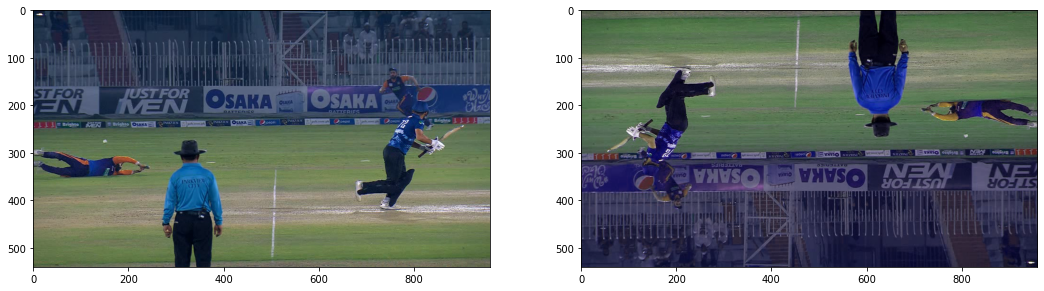

In [37]:
im = '/mnt/disk1/users/masoud/experiments/training_with_augment/ball_samples/cam1_delivery_noviz-197861-19793099.png'
img = cv2.imread(im)[..., ::-1]
aug = random.choice(aug_prob)
new_img = group_aug(img, [[12, 34, 400, 400, 'shoe']], *aug)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)
ax2.imshow(new_img['image'])
plt.show()

In [40]:
rm -r /mnt/disk1/users/masoud/experiments/training_with_augment/datasets/augmented/batsman/*

In [38]:
LABEL = 'bat'
IMG_PATH = '/mnt/disk1/users/masoud/experiments/training_with_augment/datasets/original/bat/all_images'
ANNOT_PATH = '/mnt/disk1/users/masoud/experiments/training_with_augment/datasets/original/bat/annots.json'
SAVE_PATH = f'/mnt/disk1/users/masoud/experiments/training_with_augment/datasets/augmented/{LABEL}'

assert isdir(IMG_PATH), 'No path'
assert len(glob.glob(join(IMG_PATH, '*.png'))), 'No image in path'
assert isfile(ANNOT_PATH)

if isdir(SAVE_PATH):
    shutil.rmtree(SAVE_PATH,ignore_errors=True)

makedirs(SAVE_PATH, exist_ok=True)

all_images = list(Path(IMG_PATH).glob('*'))
all_images = natsorted(all_images, key=lambda x: x.as_posix())
annotations = json.load(open(ANNOT_PATH))

annot_index = 1
image_id = 1
images_list = []
for (i, aug) in enumerate(aug_prob):
    progress_bar = tqdm(all_images)
    progress_bar.set_description(f"aug {i+1}/{len(aug_prob)}")
    for index, item in enumerate(progress_bar):
        no_bboxes = False
        annot_name = join('all_images', item.name)
        # annot_name = item.name
        temp = annotations[annot_name]
        if isinstance(temp, dict):
            temp = [temp]
        elif not len(temp):
            no_bboxes = True
        image = cv2.imread(item.as_posix())
        bboxes = []
        if not no_bboxes:
            for bbox in temp:
                x1 = int(bbox['x1'])
                y1 = int(bbox['y1'])
                x2 = int(bbox['x2'])
                y2 = int(bbox['y2'])
                bboxes.append([x1, y1, abs(x2 - x1), abs(y2 - y1), LABEL]) # COCO format for albumentations [x, y, w, h]
        else:
            # For images without bbox, we should pass empty list
            bboxes = []

        transformed = group_aug(image, bboxes, *aug)
        img = transformed['image']
        if i: # In the first round, we keep saving the original images with no augmentation
            filename = join(SAVE_PATH, item.stem + f'_transformed_{str(uuid1())[:8]}.png')
        else:
            filename = join(SAVE_PATH, item.name)
        cv2.imwrite(filename, img)
        image_and_annotation = ImageAnnotations(image_id=image_id, file_name=filename)

        if not no_bboxes:
            for bbox in transformed['bboxes']:
                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = x1 + int(bbox[2])
                y2 = y1 + int(bbox[3])
                category_id = 1

                bbox = Bbox(x1, y1, x2, y2, category_id, id_=annot_index, image_id=image_id)
                image_and_annotation.add_annotation(bbox)
                annot_index += 1

        images_list.append(image_and_annotation)

        image_id += 1

random.shuffle(images_list)
TRAIN_PATH = LABEL

coco_prepare(TRAIN_PATH, images_list, f'{LABEL}/train.json', LABEL)

  0%|          | 0/1709 [00:00<?, ?it/s]

KeyboardInterrupt: 